In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr

from datetime import datetime, timedelta

import intake
import healpy
import tobac

In [2]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [3]:
dataset = cat.ICON.ngc4008(time="PT15M", zoom=9).to_dask()

/home/b/b382728/miniconda3/envs/tobac/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [19]:
lon = xr.DataArray(np.arange(0.05, 360, 0.1), dims=("lon",), name="lon", attrs=dict(units="degrees", standard_name="longitude"))
lat = xr.DataArray(np.arange(59.95, -60, -0.1), dims=("lat",), name="lat", attrs=dict(units="degrees", standard_name="latitude"))

pix = xr.DataArray(
    healpy.ang2pix(dataset.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(lat, lon),
)


In [20]:
import warnings
import numpy as np
import pandas as pd
import xarray as xr
from iris.analysis.cartography import area_weights
from scipy.ndimage import labeled_comprehension


def get_tb(olr):
    """
    This function converts outgoing longwave radiation to brightness temperatures.

    Args:
        olr(xr.DataArray or numpy array): 2D field of model output with OLR

    Returns:
        tb(xr.DataArray or numpy array): 2D field with estimated brightness temperatures
    """
    # constants
    aa = 1.228
    bb = -1.106e-3  # K−1
    # Planck constant
    sigma = 5.670374419e-8  # W⋅m−2⋅K−4

    # flux equivalent brightness temperature
    Tf = (abs(olr) / sigma) ** (1.0 / 4)
    tb = (((aa**2 + 4 * bb * Tf) ** (1.0 / 2)) - aa) / (2 * bb)
    return tb


def calc_area_and_precip(features, segments, ds, MCS, inplace=False):
    """Calculate the area, maximum precip rate and total precip volume for each
    feature

    Parameters
    ----------
    features : _type_
        _description_
    segments : _type_
        _description_
    ds : _type_
        _description_
    MCS : _type_
        _description_

    Returns
    -------
    tracks
        _description_
    """
    if not inplace:
        features = features.copy()

    # Get area array and calculate area of each segment
    segment_slice = segments[0]
    segment_slice.coord("latitude").guess_bounds()
    segment_slice.coord("longitude").guess_bounds()
    warnings.filterwarnings(
        "ignore",
        category=UserWarning,
        message="Using DEFAULT_SPHERICAL_EARTH_RADIUS*",
    )
    area = area_weights(segment_slice, normalize=False)

    features["area"] = np.nan
    features["max_precip"] = np.nan
    features["total_precip"] = np.nan

    features_t = xr.CFTimeIndex(features["time"].to_numpy()).to_datetimeindex()
    for time, mask in zip(ds[MCS.time_dim].data, segments.slices_over("time")):
        wh = features_t == time
        if np.any(wh):
            feature_areas = labeled_comprehension(
                area, mask.data, features[wh]["feature"], np.sum, area.dtype, np.nan
            )
            features.loc[wh, "area"] = feature_areas

            step_precip = ds[MCS.precip_var].sel({MCS.time_dim: time}).values
            max_precip = labeled_comprehension(
                step_precip,
                mask.data,
                features[wh]["feature"],
                np.max,
                area.dtype,
                np.nan,
            )

            features.loc[wh, "max_precip"] = max_precip

            feature_precip = labeled_comprehension(
                area * step_precip,
                mask.data,
                features[wh]["feature"],
                np.sum,
                area.dtype,
                np.nan,
            )

            features.loc[wh, "total_precip"] = feature_precip

    return features


def max_consecutive_true(condition: np.ndarray[bool]) -> int:
    """Return the maximum number of consecutive True values in 'condition'

    Parameters
    ----------
    condition : np.ndarray[bool]
        numpy array of boolean values

    Returns
    -------
    int
        the maximum number of consecutive True values in 'condition'
    """
    if np.any(condition):
        return np.max(
            np.diff(
                np.where(
                    np.concatenate(
                        ([condition[0]], condition[:-1] != condition[1:], [True])
                    )
                )[0]
            )[::2],
            initial=0,
        )
    else:
        return 0


def is_track_mcs(features: pd.DataFrame) -> pd.DataFrame:
    """Test whether each track in features meets the condtions for an MCS

    Parameters
    ----------
    features : pd.Dataframe
        _description_

    Returns
    -------
    pd.DataFrame
        _description_
    """
    consecutive_precip_max = features.groupby("track").apply(
        lambda df: max_consecutive_true(
            df.groupby("time").max_precip.max().to_numpy() >= 10
        )
    )
    consecutive_area_max = features.groupby("track").apply(
        lambda df: max_consecutive_true(
            df.groupby("time").area.max().to_numpy() >= 4e10
        )
    )
    max_total_precip = features.groupby("track").apply(
        lambda df: df.groupby("time").total_precip.sum().max()
    )
    is_mcs = np.logical_and.reduce(
        [
            consecutive_precip_max >= 4,
            consecutive_area_max >= 4,
            max_total_precip >= 2e10,
        ]
    )
    return pd.DataFrame(data=is_mcs, index=consecutive_precip_max.index)


In [21]:
bt = get_tb(dataset.rlut.isel(time=range(48,72)).isel(cell=pix))

In [22]:
dt = 900  # in seconds
dxy = 11100  # in meter (for Latitude)

parameters_features = dict(
    dxy=dxy,
    threshold=[241, 233, 225],
    n_min_threshold=10,
    min_distance=2.5*dxy,
    target="minimum",
    position_threshold="center",
    PBC_flag="hdim_2",
    statistic={"feature_min_BT": np.nanmin},
)

parameters_tracking = dict(
    d_max=2.5*dxy,
    method_linking="predict",
    adaptive_stop=0.2,
    adaptive_step=0.95,
    stubs=2,
    memory=0,
    PBC_flag="hdim_2",
    min_h2=0,
    max_h2=3600,
)

parameters_segments = dict(
    threshold=241, target="minimum", PBC_flag="hdim_2", 
    seed_3D_flag="box", seed_3D_size=11,
)

parameters_merge = dict(
    distance=dxy*20, frame_len=2, PBC_flag="hdim_2", min_h1=0, max_h1=1800, min_h2=0, max_h2=3600,
)


In [23]:
features = tobac.feature_detection_multithreshold(
    bt.to_iris(),
    **parameters_features,
)

In [24]:
features["time"] = xr.CFTimeIndex(features["time"].to_numpy()).to_datetimeindex()

In [25]:
tracks = tobac.linking_trackpy(
    features,
    None,
    dt,
    dxy,
    **parameters_tracking,
)

Frame 23: 1643 trajectories present.


In [26]:
track_min_threshold = tracks.groupby("cell").threshold_value.min()
valid_cells = track_min_threshold.index[track_min_threshold <= 225]
valid_cells = np.setdiff1d(valid_cells, -1)
wh_in_track = np.isin(tracks.cell, valid_cells)
tracks = tracks[wh_in_track]


In [27]:
merges = tobac.merge_split.merge_split_MEST(tracks, dxy, **parameters_merge)

In [28]:
tracks["track"] = merges.feature_parent_track_id.data.astype(np.int64)

track_start_time = tracks.groupby("track").time.min()
tracks["time_track"] = tracks.time - track_start_time[tracks.track].to_numpy()

track_max_cell_len = tracks.groupby("track").apply(
    lambda df: max(df.groupby("cell").apply(len, include_groups=False))
)

valid_tracks = track_max_cell_len.index[track_max_cell_len >= 3]
wh_in_track = np.isin(tracks.track, valid_tracks)
tracks = tracks[wh_in_track]

/tmp/ipykernel_1201353/1509458684.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  track_max_cell_len = tracks.groupby("track").apply(


In [29]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message="Warning: converting a masked element to nan.*",
)
warnings.filterwarnings(
    "ignore",
    # category=FutureWarning,
    message="FutureWarning: Calling float on a sing*",
)
segments, tracks = tobac.segmentation.segmentation(
    tracks, bt.to_iris(), dxy, **parameters_segments,
)

In [30]:
gridded_precip = dataset.pr.isel(time=range(48,72)).isel(cell=pix)

In [31]:
from iris.analysis.cartography import area_weights
from scipy.ndimage import labeled_comprehension
# Get area array and calculate area of each segment
segment_slice = segments[0]
segment_slice.coord("latitude").guess_bounds()
segment_slice.coord("longitude").guess_bounds()
area = area_weights(segment_slice, normalize=False)

tracks["area"] = np.nan
tracks["max_precip"] = np.nan
tracks["total_precip"] = np.nan

# tracks_t = xr.CFTimeIndex(tracks["time"].to_numpy()).to_datetimeindex()
tracks_t = tracks["time"].to_numpy()
for time, mask in zip(bt["time"].data, segments.slices_over("time")):
    wh = tracks_t == time
    if np.any(wh):
        feature_areas = labeled_comprehension(
            area, mask.data, tracks[wh]["feature"], np.sum, area.dtype, np.nan
        )
        tracks.loc[wh, "area"] = feature_areas

        step_precip = gridded_precip.sel({"time": time}).values
        max_precip = labeled_comprehension(
            step_precip,
            mask.data,
            tracks[wh]["feature"],
            np.max,
            area.dtype,
            np.nan,
        )

        tracks.loc[wh, "max_precip"] = max_precip

        feature_precip = labeled_comprehension(
            area * step_precip,
            mask.data,
            tracks[wh]["feature"],
            np.sum,
            area.dtype,
            np.nan,
        )

        tracks.loc[wh, "total_precip"] = feature_precip

# from utils import max_consecutive_true

consecutive_precip_max = tracks.groupby("track").apply(
    lambda df: max_consecutive_true(
        df.groupby("time").max_precip.max().to_numpy() >= 10
    )
)
consecutive_area_max = tracks.groupby("track").apply(
    lambda df: max_consecutive_true(
        df.groupby("time").area.sum().to_numpy() >= 4e10
    )
)
max_total_precip = tracks.groupby("track").apply(
    lambda df: df.groupby("time").total_precip.sum().max()
)

is_mcs = np.logical_and.reduce(
    [
        consecutive_precip_max >= 4,
        consecutive_area_max >= 4,
        max_total_precip >= 2e10,
    ]
)

mcs_flag = pd.DataFrame(data=is_mcs, index=consecutive_precip_max.index)

print(np.sum(mcs_flag))

# tracks["time_feature"] = tracks["time"]

# Prepare output dataset
# print(datetime.now(), f"Preparing output", flush=True)
out_ds = tracks.set_index(tracks.feature).to_xarray()

out_ds = out_ds.rename_vars(
    {
        # "latitude": "feature_latitude",
        # "longitude": "feature_longitude",
        "time": "time_feature",
        "cell": "feature_cell_id",
        "track": "feature_track_id",
        "hdim_1": "y",
        "hdim_2": "x",
        "num": "detection_pixel_count",
        "feature_min_BT": "min_BT",
        "ncells": "segmentation_pixel_count",
    }
)

out_ds["track_is_mcs"] = mcs_flag.to_xarray()[0]

feature_is_mcs = out_ds.track_is_mcs.loc[out_ds.feature_track_id]

out_ds["feature_is_mcs"] = feature_is_mcs
out_ds["cell_track_id"] = merges.cell_parent_track_id[np.isin(merges.cell, tracks.cell)]
out_ds["track_child_cell_count"] = merges.track_child_cell_count[np.isin(merges.track, tracks.track)]
out_ds["cell_child_feature_count"] = merges.cell_child_feature_count[np.isin(merges.cell, tracks.cell)]
out_ds["cell_starts_with_split"] = merges.cell_starts_with_split[np.isin(merges.cell, tracks.cell)]
out_ds["cell_ends_with_merge"] = merges.cell_ends_with_merge[np.isin(merges.cell, tracks.cell)]

all_feature_labels = xr.DataArray.from_iris(segments)
all_feature_labels =  all_feature_labels * np.isin(
    all_feature_labels, out_ds.feature.values
)
all_feature_labels.name = "all_feature_labels"

mcs_feature_labels = all_feature_labels * np.isin(
    all_feature_labels, out_ds.feature.values[out_ds.feature_is_mcs]
)
mcs_feature_labels.name = "mcs_feature_labels"

# Map feature labels to cells and tracks
all_cell_labels = all_feature_labels.copy()
all_cell_labels.name = "all_cell_labels"
all_track_labels = all_feature_labels.copy()
all_track_labels.name = "all_track_labels"

wh_all_labels = np.flatnonzero(all_feature_labels)

all_cell_labels.data.ravel()[wh_all_labels] = out_ds.feature_cell_id.loc[
    all_feature_labels.data.ravel()[wh_all_labels]
]
all_track_labels.data.ravel()[wh_all_labels] = out_ds.feature_track_id.loc[
    all_feature_labels.data.ravel()[wh_all_labels]
]

mcs_cell_labels = mcs_feature_labels.copy()
mcs_cell_labels.name = "mcs_cell_labels"
mcs_track_labels = mcs_feature_labels.copy()
mcs_track_labels.name = "mcs_track_labels"

wh_mcs_labels = np.flatnonzero(mcs_feature_labels)

mcs_cell_labels.data.ravel()[wh_mcs_labels] = out_ds.feature_cell_id.loc[
    mcs_feature_labels.data.ravel()[wh_mcs_labels]
]
mcs_track_labels.data.ravel()[wh_mcs_labels] = out_ds.feature_track_id.loc[
    mcs_feature_labels.data.ravel()[wh_mcs_labels]
]

out_ds = out_ds.assign_coords(all_feature_labels.coords)

out_ds = xr.merge(
    [
        out_ds,
        all_feature_labels,
        mcs_feature_labels,
        all_cell_labels,
        mcs_cell_labels,
        all_track_labels,
        mcs_track_labels,
    ]
)

/home/b/b382728/miniconda3/envs/tobac/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/tmp/ipykernel_1201353/879941390.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consecutive_precip_max = tracks.groupby("track").apply(
/tmp/ipykernel_1201353/879941390.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  con

0    0
dtype: int64


In [32]:
out_ds

<xarray.Dataset> Size: 2GB
Dimensions:                   (feature: 11849, track: 433, cell: 1745,
                               time: 24, lat: 1200, lon: 3600)
Coordinates:
  * feature                   (feature) int64 95kB 243 266 271 ... 34444 34445
  * track                     (track) int64 3kB 1 2 3 4 5 ... 451 452 453 454
  * cell                      (cell) int64 14kB 243 266 271 ... 9528 9529 9530
  * time                      (time) datetime64[ns] 192B 2020-01-01T12:15:00 ...
  * lat                       (lat) float64 10kB 59.95 59.85 ... -59.85 -59.95
  * lon                       (lon) float64 29kB 0.05 0.15 0.25 ... 359.9 360.0
Data variables: (12/32)
    frame                     (feature) int64 95kB 0 0 0 0 0 ... 23 23 23 23 23
    idx                       (feature) int64 95kB 630 760 772 ... 4672 4675
    y                         (feature) float64 95kB 517.6 564.2 ... 1.034e+03
    x                         (feature) float64 95kB 2.348e+03 ... 2.034e+03
    detection_pixel_count     (feature) int64 95kB 18 12 17 29 ... 11 67 14 25
    threshold_value           (feature) int64 95kB 241 241 241 ... 225 225 225
    ...                        ...
    all_feature_labels        (time, lat, lon) int32 415MB 0 0 0 0 0 ... 0 0 0 0
    mcs_feature_labels        (time, lat, lon) int32 415MB 0 0 0 0 0 ... 0 0 0 0
    all_cell_labels           (time, lat, lon) int32 415MB 0 0 0 0 0 ... 0 0 0 0
    mcs_cell_labels           (time, lat, lon) int32 415MB 0 0 0 0 0 ... 0 0 0 0
    all_track_labels          (time, lat, lon) int32 415MB 0 0 0 0 0 ... 0 0 0 0
    mcs_track_labels          (time, lat, lon) int32 415MB 0 0 0 0 0 ... 0 0 0 0

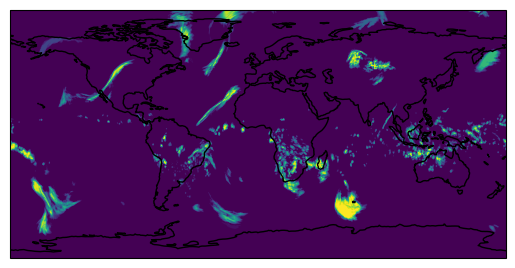

In [33]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
ax.imshow((out_ds.all_feature_labels!=0).mean("time"), vmin=0, vmax=1, extent=[0,360,-90,90])